In [1]:
import numpy as np
import pandas as pd
import torch, os, dpyscfl, dpyscf, ogdpyscf
from pyscf import scf, gto, cc
from ase.io import read, write
from ase import Atoms
import matplotlib.pyplot as plt

from dpyscfl.net import get_scf as dpyscfl_get
from dpyscf.net import lite_get_scf as dpyscf_get
from ogdpyscf.net import lite_get_scf as ogdpyscf_get

In [2]:
xcdd = '/home/awills/Documents/Research/dpyscfl/models/xcdiff/MODEL_MGGA/xc'


net_lite = dpyscfl_get('MGGA', path=xcdd)
net = dpyscf_get('MGGA', path=xcdd)
net_og = ogdpyscf_get('MGGA', path=xcdd)
nets = {'dpyscf_lite': net_lite,
       'dpyscf' : net,
       'ogdpyscf' : net_og}

FREEC False
FREEC False
FREEC False


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


# Compare Network Architectures

In [3]:
for k, v in nets.items():
    print('-----------------------------')
    print(k)
    print(v.xc.grid_models)
    print('-----------------------------')

-----------------------------
dpyscf_lite
ModuleList(
  (0): XC_L(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): GELU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): GELU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): GELU()
      (6): Linear(in_features=16, out_features=1, bias=True)
    )
    (tanh): Tanh()
    (lobf): LOB(
      (sig): Sigmoid()
    )
    (sig): Sigmoid()
  )
  (1): C_L(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): GELU()
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): GELU()
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): GELU()
      (6): Linear(in_features=16, out_features=1, bias=True)
      (7): Softplus(beta=1, threshold=20)
    )
    (sig): Sigmoid()
    (tanh): Tanh()
    (lobf): LOB(
      (sig): Sigmoid()
    )
  )
)
-----------------------------
---------

- Lite XC_L : L>G>L>G>L>G>L
- Dpys XC_L : L>G>L>G>L>G>L
- Ogdp XC_L : L>G>L>G>L>G>L


- Lite C_L : L>G>L>G>L>G>L>S
- Dpys C_L : L>G>L>G>L>G>L>S
- Ogdp C_L : L>G>L>G>L>G>L

So `ogdpyscf` doesn't have this Softplus factor in the correlation network.

# Compare Network Weights

In [4]:
params = {'dpyscf_lite': [],
       'dpyscf' : [],
       'ogdpyscf' : []}
for k, v in nets.items():
    print(k)
    for name, param in v.xc.grid_models.named_parameters():
        print(name, param)
        params[k].append(param)

dpyscf_lite
0.net.0.weight Parameter containing:
tensor([[ -1.7256,  -0.7583],
        [ -0.7135,  -0.4243],
        [ -0.0929,  -4.0847],
        [  0.1295,  -0.6161],
        [-11.2182,  -1.2587],
        [-47.5842,   0.0798],
        [ -7.2921,  -0.4032],
        [ -0.4546,   0.1030],
        [ -1.5343,  -1.2948],
        [ -3.5488,  -2.6906],
        [  0.8545,   0.3988],
        [ -1.1457,   0.0605],
        [ -3.8406,   0.0731],
        [ -0.6009,   0.1400],
        [  0.7541,  -0.1070],
        [ -2.9376,  -0.1989]], requires_grad=True)
0.net.0.bias Parameter containing:
tensor([ 1.0763,  0.9693, -0.1023,  0.1779, -2.7520,  0.3602, -0.3192,  1.3729,
        -0.1036, -1.5152, -0.5317,  0.4798,  0.6637,  0.4314, -0.0635,  0.3054],
       requires_grad=True)
0.net.2.weight Parameter containing:
tensor([[ 6.0538e-01,  5.7704e-01, -1.5514e-01, -4.3712e-01, -4.1702e-01,
          4.4142e-01, -1.7892e+00,  3.7946e-01, -8.9567e-01, -6.5957e+00,
         -4.4777e-01,  6.5842e-01,  8.0520

In [5]:
kref = 'dpyscf_lite'
sumtot = 0
for k, v in params.items():
    if k == kref:
        continue
    print('-------------------------')
    print('-------------------------')
    print('-------------------------')
    print(k, len(v))
    for idx, v in enumerate(params[k]):
        diff = params[kref][idx] - params[k][idx]
        print(diff)
    print('-------------------------')
    print('-------------------------')
    print('-------------------------')


-------------------------
-------------------------
-------------------------
dpyscf 16
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<SubBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

So all the weights are in fact the same when read in, as they should be.

# Compare Training Data

#### First check -- density matrix shapes in Sebastian's "reference data" folder

In [6]:
srp = '/home/awills/Documents/Research/xcdiff/data/ref/6-311'
srpdms = sorted([i for i in os.listdir(srp) if 'dm' in i], key = lambda x: int(x.split('.')[0]))
for dmp in srpdms:
    dm = np.load(os.path.join(srp, dmp))
    print(dm.shape)
print('-----------')
print('-----------')
print('-----------')
print('-----------')
print('-----------')
sdp = '/home/awills/Documents/Research/xcdiff/data/ccsdt'
sdpdms = sorted([i for i in os.listdir(sdp) if 'dm' in i and '_' not in i], key = lambda x: int(x.split('.')[0]))
for dmp in sdpdms:
    dm = np.load(os.path.join(sdp, dmp))
    print(dm.shape)

(2, 30, 30)
(2, 78, 78)
(2, 78, 78)
(2, 93, 93)
(2, 117, 117)
(2, 94, 94)
(2, 78, 78)
(2, 78, 78)
(2, 108, 108)
(2, 78, 78)
(2, 62, 62)
(2, 54, 54)
(2, 94, 94)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 15, 15)
(2, 39, 39)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 78, 78)
(2, 54, 54)
(2, 54, 54)
-----------
-----------
-----------
-----------
-----------
(2, 78, 78)
(2, 86, 86)
(2, 30, 30)
(2, 54, 54)
(2, 94, 94)
(2, 94, 94)
(2, 62, 62)
(2, 86, 86)
(2, 93, 93)
(2, 195, 195)
(2, 99, 99)
(2, 117, 117)
(2, 133, 133)
(2, 117, 117)
(2, 54, 54)
(2, 69, 69)
(2, 77, 77)
(2, 94, 94)
(2, 93, 93)
(2, 93, 93)
(2, 62, 62)
(2, 117, 117)
(2, 156, 156)
(2, 117, 117)
(2, 78, 78)
(2, 78, 78)
(2, 54, 54)
(2, 164, 164)
(2, 92, 92)
(2, 94, 94)
(2, 125, 125)
(2, 86, 86)
(2, 315, 315)
(2, 177, 177)
(2, 123, 123)
(2, 153, 153)
(2, 227, 227)
(2, 123, 123)
(2, 131, 131)
(2, 171, 171)
(2, 156, 156)
(2, 164, 164)
(2, 108, 108)
(2, 108, 108)
(2, 164, 164)
(2, 125, 125)
(2, 101, 101)
(2, 94, 94)
(2, 203, 203)
(2, 92, 92

## ALL OF SEBASTIAN'S DENSITY MATRIX REFERENCES ARE POLARIZED, 
seemingly ignoring any flags that would indicate closed/open shell calculations. Checking my own reference from CCSD(T):

In [10]:
xcdp = '/home/awills/Documents/Research/swxcd/aegis/xcdccsdt_ps'
#after starting the subset generation, this became the default full set directory I was using
xcdp2 = '/home/awills/Documents/Research/swxcd/aegis/test_subset_ps2/09'
dms = sorted([i for i in os.listdir(xcdp) if '.dm' in i], key = lambda x: int(x.split('_')[0]))
for idx, dm in enumerate(dms):
    arr = np.load(os.path.join(xcdp, dm))
    print(idx, dm, arr.shape)
print('==========================================')    
dms = sorted([i for i in os.listdir(xcdp2) if '.dm' in i and '_' in i], key = lambda x: int(x.split('_')[0]))
for idx, dm in enumerate(dms):
    try:
        arr = np.load(os.path.join(xcdp, dm))
        print(idx, dm, arr.shape)
    except:
        pass

0 0_H2.dm.npy (2, 30, 30)
1 1_N2.dm.npy (2, 78, 78)
2 2_LiF.dm.npy (2, 78, 78)
3 3_CNH.dm.npy (2, 93, 93)
4 4_CO2.dm.npy (2, 117, 117)
5 5_Cl2.dm.npy (2, 94, 94)
6 6_F2.dm.npy (2, 78, 78)
7 7_O2.dm.npy (2, 78, 78)
8 8_C2H2.dm.npy (2, 108, 108)
9 9_OC.dm.npy (2, 78, 78)
10 10_ClH.dm.npy (2, 62, 62)
11 11_LiH.dm.npy (2, 54, 54)
12 12_Na2.dm.npy (2, 94, 94)
13 13_C.dm.npy (2, 39, 39)
14 14_Cl.dm.npy (2, 47, 47)
15 15_F.dm.npy (2, 39, 39)
16 16_H.dm.npy (2, 15, 15)
17 17_Li.dm.npy (2, 39, 39)
18 18_N.dm.npy (2, 39, 39)
19 19_Na.dm.npy (2, 47, 47)
20 20_O.dm.npy (2, 39, 39)
21 21_NO.dm.npy (2, 78, 78)
22 22_NO2.dm.npy (2, 117, 117)
23 23_NH.dm.npy (2, 54, 54)
24 24_O3.dm.npy (2, 117, 117)
25 25_N2O.dm.npy (2, 117, 117)
26 26_CH3.dm.npy (2, 84, 84)
27 27_CH2.dm.npy (2, 69, 69)
28 28_OH2.dm.npy (2, 69, 69)
29 29_NH3.dm.npy (2, 84, 84)
30 30_OH.dm.npy (2, 54, 54)
31 31_CH.dm.npy (2, 54, 54)
32 32_H.dm.npy (2, 15, 15)
33 33_N2O.dm.npy (2, 117, 117)
34 34_HON2.dm.npy (2, 132, 132)
35 35_OH.dm.np

all are also spin polarized.

Case study: the first molecule in the G2/97 Dataset. Unclear whether Sebastian used the default MO rep that the CC make_rdm1() function generates, or the AO rep that seems to be default everywhere else besides the CC calculations.

(See, for instance, [the `pyscf.cc.ccsd_t` module docs,](https://pyscf.org/pyscf_api_docs/pyscf.cc.html#module-pyscf.cc.ccsd_t) where `ao_repr = False` by default (and in the other relevant modules), as opposed to the [Hartree Fock](https://pyscf.org/pyscf_api_docs/pyscf.scf.html#module-pyscf.scf.hf) module (where the docs explicitly say it's made in the AO rep).

In [9]:
g2 = read('/home/awills/Documents/Research/swxcd/aegis/g297_ps/caresults_os.traj', ':')
seben = np.loadtxt('/home/awills/Documents/Research/xcdiff/data/ccsdt/progress')
sdm = np.load('/home/awills/Documents/Research/xcdiff/data/ccsdt/0.dm.npy')
atoms = g2[0]
print(atoms.symbols, atoms.info)
pos = atoms.positions
spec = atoms.get_chemical_symbols()
mol_input = [[s,p] for s,p in zip(spec,pos)]

mol = gto.M(atom=mol_input, basis='6-311++G(3df,2pd)', spin=0, charge=0)
mf = scf.UHF(mol)
mf.run()
mycc = cc.CCSD(mf)
mycc.kernel()
ccsdt = mycc.ccsd_t()

aodm = mycc.make_rdm1(ao_repr=True)
modm = mycc.make_rdm1()

OC {'CO': True, 'energy': -113.20173021777055, 'atomization': 0.4142335363320095, 'atomization_ev': 11.271868661369064, 'atomization_H': 0.4142335363320095, 'openshell': False, 'name': 'Carbon monoxide'}
converged SCF energy = -112.779199082437  <S^2> = 2.8332892e-12  2S+1 = 1
E(UCCSD) = -113.184009108928  E_corr = -0.4048100264909328
UCCSD(T) correction = -0.0177211075869212


In [10]:
se = seben[0, 1]
errdev = abs((mycc.e_tot + ccsdt) - se)

#ao dev from sebastian
aomax = np.max(abs(sdm-aodm))
aomae = np.mean(abs(sdm-aodm))
aosum = np.sum(abs(sdm-aodm))

#mo dev from sebastian
momax = np.max(abs(sdm-modm))
momae = np.mean(abs(sdm-modm))
mosum = np.sum(abs(sdm-modm))

print("=====================")
print("{}: Absolute CCSD(T) Energy Difference".format(atoms.symbols))
print("|E_alec - E_seb| = {}".format(errdev))
print('---------------------')
print("{}: AO Rep DM Deviations".format(atoms.symbols))
print("Max( | Alec_AO_DM - Seb_DM | ) = {}".format(aomax))
print("Mean( | Alec_AO_DM - Seb_DM | ) = {}".format(aomae))
print("Sum( | Alec_AO_DM - Seb_DM | ) = {}".format(aosum))
print('---------------------')
print("{}: MO Rep DM Deviations".format(atoms.symbols))
print("Max( | Alec_MO_DM - Seb_DM | ) = {}".format(momax))
print("Mean( | Alec_MO_DM - Seb_DM | ) = {}".format(momae))
print("Sum( | Alec_MO_DM - Seb_DM | ) = {}".format(mosum))
print("=====================")

OC: Absolute CCSD(T) Energy Difference
|E_alec - E_seb| = 1.1368683772161603e-13
---------------------
OC: AO Rep DM Deviations
Max( | Alec_AO_DM - Seb_DM | ) = 1.51639811818427e-12
Mean( | Alec_AO_DM - Seb_DM | ) = 1.0466061461594074e-14
Sum( | Alec_AO_DM - Seb_DM | ) = 1.273510358646767e-10
---------------------
OC: MO Rep DM Deviations
Max( | Alec_MO_DM - Seb_DM | ) = 0.9570946464748263
Mean( | Alec_MO_DM - Seb_DM | ) = 0.0037595085328351596
Sum( | Alec_MO_DM - Seb_DM | ) = 45.745699827538225


Given the large errors in the `Alec_MO_DM - Seb_DM`, I assume his density matrices are indeed in the AO rep.

### Sebastian's CCSD(T) energies against mine

In [34]:
chkpts

['0.chkpt',
 '1.chkpt',
 '2.chkpt',
 '3.chkpt',
 '4.chkpt',
 '5.chkpt',
 '6.chkpt',
 '7.chkpt',
 '8.chkpt',
 '9.chkpt',
 '10.chkpt',
 '11.chkpt',
 '12.chkpt',
 '13.chkpt',
 '14.chkpt',
 '15.chkpt',
 '16.chkpt',
 '17.chkpt',
 '18.chkpt',
 '19.chkpt',
 '20.chkpt',
 '21.chkpt',
 '22.chkpt',
 '23.chkpt',
 '24.chkpt',
 '25.chkpt',
 '26.chkpt',
 '27.chkpt',
 '28.chkpt',
 '29.chkpt',
 '30.chkpt',
 '31.chkpt',
 '32.chkpt',
 '33.chkpt',
 '34.chkpt',
 '35.chkpt',
 '36.chkpt',
 '37.chkpt',
 '38.chkpt',
 '39.chkpt',
 '40.chkpt',
 '41.chkpt',
 '42.chkpt',
 '43.chkpt',
 '44.chkpt',
 '45.chkpt',
 '46.chkpt',
 '47.chkpt',
 '48.chkpt',
 '49.chkpt',
 '50.chkpt',
 '51.chkpt',
 '52.chkpt',
 '53.chkpt',
 '54.chkpt',
 '55.chkpt',
 '56.chkpt',
 '57.chkpt',
 '58.chkpt',
 '59.chkpt',
 '60.chkpt',
 '61.chkpt',
 '62.chkpt',
 '63.chkpt',
 '64.chkpt',
 '65.chkpt',
 '66.chkpt',
 '67.chkpt',
 '68.chkpt',
 '69.chkpt',
 '70.chkpt',
 '71.chkpt',
 '72.chkpt',
 '73.chkpt',
 '74.chkpt',
 '75.chkpt',
 '76.chkpt',
 '77.chkp

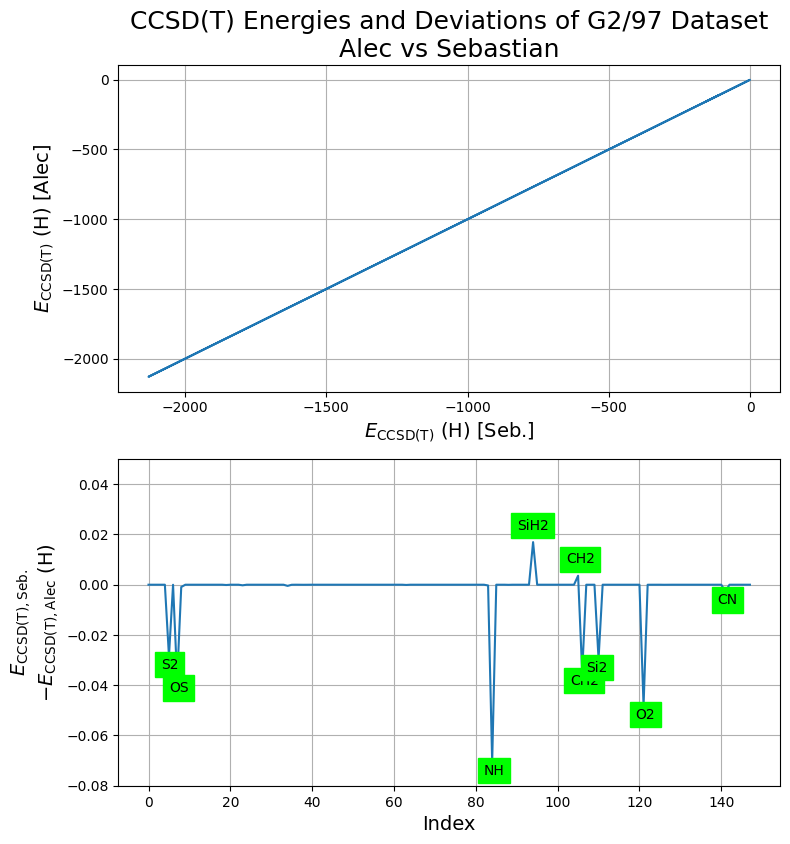

In [46]:
sebep = '/home/awills/Documents/Research/xcdiff/data/ccsdt'
seben = np.loadtxt(os.path.join(sebep, 'progress'))
alp = '/home/awills/Documents/Research/swxcd/aegis/g297_ps'
sebdm = sorted([i for i in os.listdir(sebep) if 'dm' in i and '_' not in i], key = lambda x: int(x.split('.')[0]))
aldm = sorted([i for i in os.listdir(alp) if 'dm' in i] , key = lambda x: int(x.split('_')[0]))


alen = pd.read_csv('/home/awills/Documents/Research/swxcd/aegis/g297_ps/progress', delimiter='\t')
xcd = read('/home/awills/Documents/Research/swxcd/aegis/g297_ps/caresults_os.traj', ':')
alen.columns = [i.strip() for i in alen.columns]
alen['atoms.symbols'] = alen['atoms.symbols'].str.strip()
altrj = read('/home/awills/Documents/Research/swxcd/aegis/g297_ps/caresults_os.traj', ':')
#results.traj file completely useless, some random collection of molecules that aren't even the whole dataset.
#sebt = read(os.path.join(sebep, 'results.traj'), ':')
chkpts = sorted([i for i in os.listdir(sebep) if 'chkpt' in i], key = lambda x: int(x.split('.')[0]))
atoms = []
maxdmes = []
meandmes = []
sumdmes = []
ordes = []
for idx, ic in enumerate(chkpts):
    #print("{}: {}".format(idx, ic))
    tmp = scf.chkfile.load_scf(os.path.join(sebep, ic))
    atom = tmp[0].atom
    astr = ''.join([at[0] for at in atom])
    #print('CHECKPOINTED ATOM: {}'.format(astr))
    apos = [at[1] for at in atom]
    atobj = Atoms(astr, positions = apos)
    atobj.info['energy'] = seben[idx]
    atoms.append(Atoms(astr, positions = apos))
    ordes.append(altrj[idx].info['energy'])
    
    adm = np.load(os.path.join(alp, aldm[idx]))
    sdm = np.load(os.path.join(sebep, sebdm[idx]))
    
    if len(sdm.shape) > len(adm.shape):
        #average polarizations
        sdm = (sdm[0] + sdm[1])/2
    
    #print(adm.shape, sdm.shape)
    maxdmes.append(np.max(adm-sdm))
    meandmes.append(np.mean(adm-sdm))
    sumdmes.append(np.sum(abs(adm-sdm)))
    
cols = alen.columns
symbs = [str(at.symbols) for at in atoms]
xcdsym = [str(at.symbols) for at in xcd]
# ordes = np.array([alen[alen['atoms.symbols'] == sym][cols[2]].values[0] for sym in symbs])

f = plt.figure(figsize=(8,12))
eax = f.add_subplot(311)
dax = f.add_subplot(312)
axes = [eax,dax]
dev = seben[:, 1]-ordes
eax.plot(seben[:, 1], ordes)
dax.plot(dev)

for ax in axes:
    ax.grid()
for idx, d in enumerate(dev):
    if abs(d) > 0.001:
        if symbs[idx] in xcdsym:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#00ff00")
        else:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#afafaf")

eax.set_ylabel('$E_\mathrm{CCSD(T)}$ (H) [Alec]', fontsize=14)
eax.set_xlabel('$E_\mathrm{CCSD(T)}$ (H) [Seb.]', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('$E_\mathrm{CCSD(T),Seb.}$\n$- E_\mathrm{CCSD(T),Alec}$ (H)', fontsize=14)

dax.set_ylim(-0.08, 0.05)

eax.set_title('CCSD(T) Energies and Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)

plt.tight_layout()

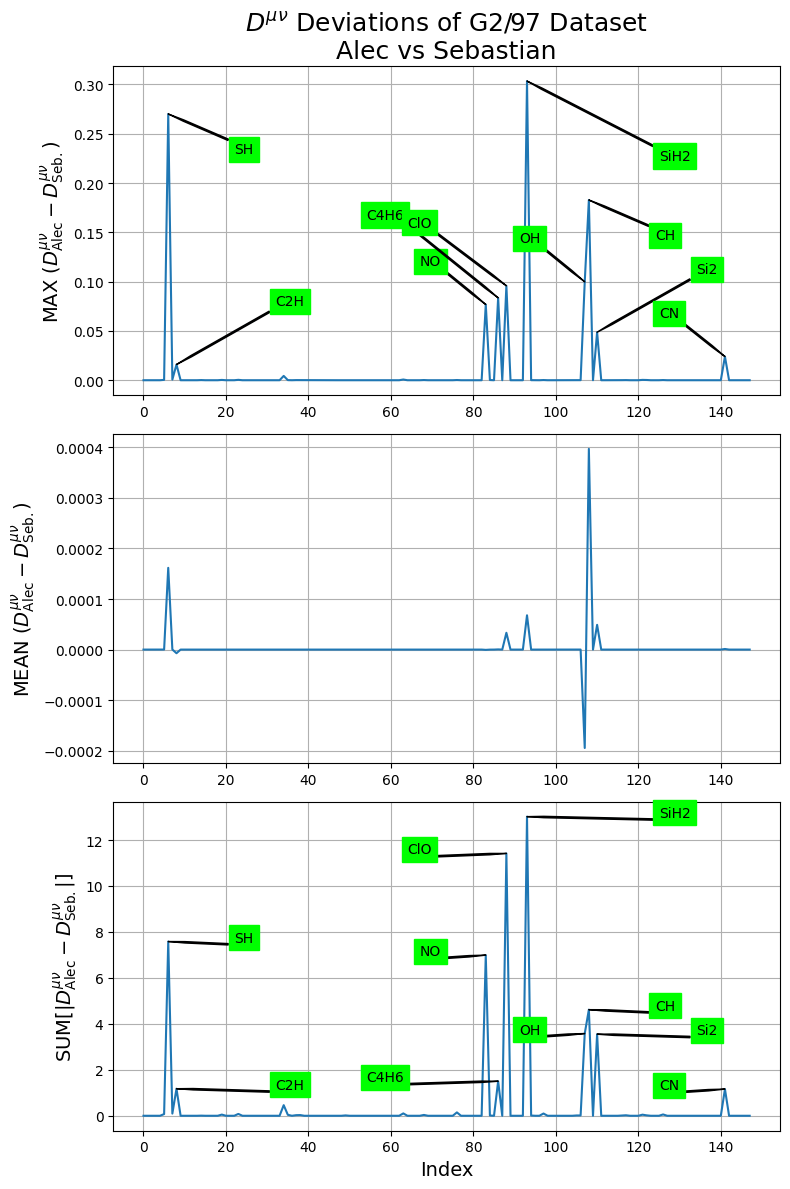

In [90]:
f = plt.figure(figsize=(8,12))
dmax = f.add_subplot(311)
dmean = f.add_subplot(312, sharex=dmax)
dsum = f.add_subplot(313, sharex=dmean)
axes = [dmax,dmean,dsum]
dmax.plot(maxdmes)
dmean.plot(meandmes)
dsum.plot(sumdmes)
for ax in axes[:3]:
    ax.grid()

# dmax.set_ylim(0, 50)
dsel = 0.01
for idx, d in enumerate(maxdmes):
    if d > dsel:
        if symbs[idx] in xcdsym:
            xmult, ymult = (1, 1)
            if symbs[idx] in ['SH','SiH2', 'CH']:
                xmult, ymult = (-1, -1)
            elif symbs[idx] in ['C2H', 'Si2']:
                xmult, ymult = (-1, 1)
#             dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
#                         backgroundcolor="#00ff00", alpha=0.01)
            dmax.annotate(symbs[idx], xy=(idx, d), xytext=(idx-xmult*8*len(symbs[idx]), d+ymult*2*len(symbs[idx])*dsel), 
                          arrowprops={'width':1, 'headwidth':1},
                        backgroundcolor="#00ff00")
        else:
#             dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
#                         backgroundcolor="#afafaf")
            dmax.annotate(symbs[idx], xy=(idx, d), xytext=(idx, d+len(symbs[idx])*dsel), 
                          arrowprops={'width':1},
                        backgroundcolor="#afafaf")

# dsum.set_ylim(0, 650)
dsel=1
for idx, d in enumerate(sumdmes):
    if d > dsel:
        if symbs[idx] in xcdsym:
            xmult, ymult = (1, 1)
            if symbs[idx] in ['SH','SiH2', 'CH']:
                xmult, ymult = (-1, -1)
            elif symbs[idx] in ['C2H', 'Si2']:
                xmult, ymult = (-1, 1)
#             dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
#                         backgroundcolor="#00ff00", alpha=0.01)
            dsum.annotate(symbs[idx], xy=(idx, d), xytext=(idx-xmult*8*len(symbs[idx]), d), 
                          arrowprops={'width':1, 'headwidth':1},
                        backgroundcolor="#00ff00")
        else:
#             dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
#                         backgroundcolor="#afafaf")
            dsum.annotate(symbs[idx], xy=(idx, d), xytext=(idx, d+len(symbs[idx])*dsel), 
                          arrowprops={'width':1},
                        backgroundcolor="#afafaf")

            
            
dmax.set_ylabel('MAX $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dmean.set_ylabel('MEAN $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dsum.set_ylabel('SUM[$|D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.}|$]', fontsize=14)
dsum.set_xlabel('Index', fontsize=14)

dmax.set_title('$D^{\mu\\nu}$ Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)


plt.tight_layout()

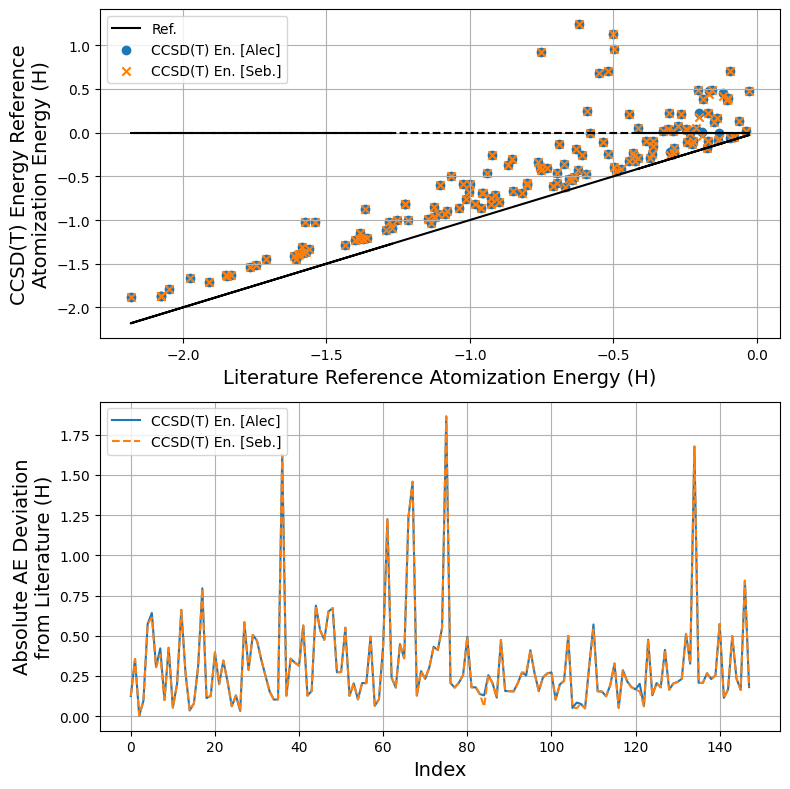

In [64]:
from ase.units import Hartree

sat = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/single_atoms.traj', ':')
g2traj = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/g2_97.traj', ':')
atend = {str(at.symbols):0 for at in sat}
atend['Al'] = -242.346
atend['B'] = -24.65391
atend['Be'] = -14.66736
atend['C'] = -37.8450
atend['Cl'] = -460.148
atend['F'] = -99.7339
atend['H'] = -0.5
atend['Li'] = -7.47806
atend['N'] = -54.5892
atend['Na'] = -162.2546
atend['O'] = -75.0673
atend['P'] = -341.259
atend['S'] = -398.110
atend['Si'] = -289.359

accsdt_aes = []
sccsdt_aes = []
ref_aes = []
for idx, at in enumerate(altrj):
    syms = at.get_chemical_symbols()
    e = at.calc.results['energy']
    se = seben[idx][1]
    for s in syms:
        e -= atend[s]
        se -= atend[s]
    #print(at.symbols, e)
    accsdt_aes.append(e)
    sccsdt_aes.append(se)
    
    refat = g2traj[idx].calc.results['energy']/Hartree
    ref_aes.append(-refat)
    
ref_aes = np.array(ref_aes)
accsdt_aes = np.array(accsdt_aes)
sccsdt_aes = np.array(sccsdt_aes)

f = plt.figure(figsize=(8,8))
eax = f.add_subplot(211)
dax = f.add_subplot(212)
adev = abs(ref_aes - accsdt_aes)
sdev = abs(ref_aes - sccsdt_aes)

eax.plot(ref_aes, ref_aes, 'k-', label='Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')
eax.scatter(ref_aes, accsdt_aes, label='CCSD(T) En. [Alec]')
eax.scatter(ref_aes, sccsdt_aes, marker='x', label='CCSD(T) En. [Seb.]')

dax.plot(adev, label='CCSD(T) En. [Alec]')
dax.plot(sdev, '--', label='CCSD(T) En. [Seb.]')

dax.grid()
eax.grid()

eax.set_xlabel("Literature Reference Atomization Energy (H)",fontsize=14)
eax.set_ylabel('CCSD(T) Energy Reference\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('Absolute AE Deviation\nfrom Literature (H)', fontsize=14)

eax.legend()
dax.legend(loc='upper left')

plt.tight_layout()
